In [ ]:
# Import all libraries and dependencies
import json
import spacy
import random
import numpy as np
import pandas as pd
from random import shuffle
from spacy.tokens import Doc
from spacy.tokens import Span
from string import punctuation
from spacy.scorer import Scorer
from collections import Counter
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy.training.example import Example

## 1. Step: Know the data and clean the data

In [ ]:
# Import training dataset
from google.colab import files
# uploaded = files.upload()
#read the file
ttt = pd.read_csv('Train_Tagged_Titles.tsv', on_bad_lines = 'skip', sep = '\t')
ttt = ttt.replace(np.nan, 'Brand', regex=True)
#read the file
lt_sm = pd.read_csv('Listing_Titles_sm.tsv')

In [ ]:
# File i/o
def load_data(file):
  with open(file, 'r', encoding = 'utf-8') as f:
    data = json.load(f)
  return (data)

def save_data(file, data):
  with open(file, 'w', encoding = 'utf-8') as f:
    json.dump(data, f, indent = 4)

## 2. Step: Build a base model to recognize patterns
### Use entity ruler to create `rules based` NER model and save to file

In [ ]:
# Get all of the unique tags from ttt dataframe and change them to a list format
all_tags = ttt["Tag"].unique().tolist()

# Create an empty list to collect all the patterns of the entity
patterns = []
# Get all of the tag names
for tag in all_tags:
  # Save list of Tokens under the tag name
  items = ttt["Token"].loc[ttt["Tag"] == f"{tag}"].tolist()
  # Loops through created list of Tokens
  for item in items:
    # Adds the new pattern to pattens list
    patterns.append({'label': f'{tag}', 'pattern': item})

In [ ]:
# Show patterns examples
print(patterns[:10])
print(patterns[-10:])

[{'label': 'Brand', 'pattern': 'LOUIS'}, {'label': 'Brand', 'pattern': 'VUITTON'}, {'label': 'Brand', 'pattern': 'LOUIS'}, {'label': 'Brand', 'pattern': 'VUITTON'}, {'label': 'Brand', 'pattern': 'Noe'}, {'label': 'Brand', 'pattern': 'LOUIS'}, {'label': 'Brand', 'pattern': 'VUITTON'}, {'label': 'Brand', 'pattern': 'LV'}, {'label': 'Brand', 'pattern': 'GUCCI'}, {'label': 'Brand', 'pattern': 'Gucci'}]
[{'label': 'Lining Material', 'pattern': 'lamb'}, {'label': 'Lining Material', 'pattern': 'Satin'}, {'label': 'Strap Drop', 'pattern': '12CM'}, {'label': 'Strap Drop', 'pattern': '18'}, {'label': 'Strap Drop', 'pattern': '23'}, {'label': 'Handle Drop', 'pattern': '24CM'}, {'label': 'Handle Drop', 'pattern': 'SHORT'}, {'label': 'Handle Drop', 'pattern': 'Long'}, {'label': 'Handle Drop', 'pattern': '11-inch'}, {'label': 'Handle Drop', 'pattern': 'Strap'}]


In [ ]:
# Create rules based ner model
def generate_rules(patterns):

  # Create a blank English model
  nlp = spacy.blank('en')
  # Create the entity ruler and add to entity pipeline
  ruler = nlp.add_pipe('entity_ruler')
  # add patterns list to model
  ruler.add_patterns(patterns)

  # Save model with patterns
  nlp.to_disk('./ebay_rules_ner')

# call function
generate_rules(patterns)

## Now we have a model that can identify patterns and tag them correctly
---
## 3. Step: Test the base NER model

In [ ]:
# Load model
nlp = spacy.load('./ebay_rules_ner')

In [ ]:
# Collecting testing dataset from Listing Title Small (lt_sm) dataset and convert testing data to list format
sentance_list = lt_sm['Title'].tolist()
test = sentance_list[35:45]
test

['Marc Jacobs Black Leather Crossbody Bag ( M0013555-001 ) $ 275.00 NWT',
 'Mimco Echo tote bag - Used but in New condition',
 'Laurel Burch purse hand bag cut out cats geometric 15x9x4 brown',
 "VERSACE JEANS women 's CLUTCH E1VVBBUX_71494",
 'Brighton Handbag Shoulder Bag Tote Raised Flowers Vines Enamel Butterfly',
 '2021 Solid Jacquemus Crocodile Pattern Mini Crossbody Handbag Shoulder Bag',
 'Fossil Small Green Leather Crossbody Shoulder Bag Brass Adjustable w / key Mint',
 'COACH F10909 Soho Black Leather Hobo Shoulder satchel FLAWLESS !',
 '( Velours-Grün ) - Bags4Less Messenger Bag , Velours-Grün ( Green ) - F3151_230 . Fr',
 'Tesco Cute Peter Rabbit Beatrix Potter Shopping Tote Bag New']

In [ ]:
# Pass test data into base ner model to extract entities and tags
for i in test:
    doc = nlp(i)
    results = []
    for ent in doc.ents:
      results.append([ent.text,ent.label_])
    print(results)

[['Marc', 'Product Line'], ['Jacobs', 'Brand'], ['Black', 'Brand'], ['Leather', 'Material'], ['Crossbody', 'Type'], ['Bag', 'Type'], ['(', 'No Tag'], ['-', 'No Tag'], ['001', 'No Tag'], [')', 'No Tag'], ['$', 'No Tag'], ['NWT', 'No Tag']]
[['tote', 'Brand'], ['bag', 'Brand'], ['-', 'No Tag'], ['Used', 'Obscure'], ['in', 'Obscure'], ['New', 'No Tag'], ['condition', 'No Tag']]
[['Laurel', 'Pattern'], ['Burch', 'Brand'], ['purse', 'Type'], ['hand', 'Brand'], ['bag', 'Obscure'], ['out', 'No Tag'], ['brown', 'Color']]
[['VERSACE', 'Brand'], ['JEANS', 'Brand'], ['women', 'Department'], ["'s", 'Brand'], ['CLUTCH', 'Brand']]
[['Brighton', 'Brand'], ['Handbag', 'Type'], ['Shoulder', 'Handle Style'], ['Bag', 'Brand'], ['Tote', 'Brand'], ['Raised', 'No Tag'], ['Flowers', 'Brand'], ['Vines', 'Pattern'], ['Enamel', 'Brand'], ['Butterfly', 'Pattern']]
[['2021', 'No Tag'], ['Solid', 'No Tag'], ['Crocodile', 'Pattern'], ['Pattern', 'No Tag'], ['Mini', 'Model'], ['Crossbody', 'Brand'], ['Handbag', 'Typ

## Model works! We need a machine learning model to operate on more complex situations: brand new data with typos
---
## 4. Step: Create NER training set using the rules based model

In [ ]:
# Load model
nlp = spacy.load('./ebay_rules_ner') 

# Create training data
TRAIN_DATA = []
for item in ttt['Title'].unique().tolist():
  doc = nlp(item)
  entities = []
  for ent in doc.ents:
    entities.append((ent.start_char, ent.end_char, ent.label_)) 
  if len(entities) > 0:
    TRAIN_DATA.append([item, {'entities': entities}]  )

# Save training data
save_data('./ebay_training_data.json', TRAIN_DATA)


In [ ]:
# Show TRAIN_DATA example
print(TRAIN_DATA[0])
print(f'We have {len(TRAIN_DATA)} sets of training data.')

['LOUIS VUITTON M40096 Handbag Priscilla Multi-color canvas Multi-color canvas', {'entities': [(0, 5, 'Product Line'), (6, 13, 'Brand'), (14, 20, 'MPN'), (21, 28, 'Type'), (29, 38, 'Model'), (39, 50, 'Color'), (51, 57, 'Brand'), (58, 69, 'Color'), (70, 76, 'Brand')]}]
We have 3471 sets of training data.


## 5. Step: Train a custom machine learning NER model with TRAIN_DATA

In [ ]:
# Load training dataset
TRAIN_DATA = load_data('./ebay_training_data.json')
TRAIN_DATA

[['LOUIS VUITTON M40096 Handbag Priscilla Multi-color canvas Multi-color canvas',
  {'entities': [[0, 5, 'Product Line'],
    [6, 13, 'Brand'],
    [14, 20, 'MPN'],
    [21, 28, 'Type'],
    [29, 38, 'Model'],
    [39, 50, 'Color'],
    [51, 57, 'Brand'],
    [58, 69, 'Color'],
    [70, 76, 'Brand']]}],
 ['LOUIS VUITTON Petit Noe Drawstring Shoulder Bag Monogram Leather M42226 39SD442',
  {'entities': [[0, 5, 'Product Line'],
    [6, 13, 'Brand'],
    [14, 19, 'Brand'],
    [20, 23, 'Brand'],
    [24, 34, 'Closure'],
    [35, 43, 'Handle Style'],
    [44, 47, 'Brand'],
    [48, 56, 'Brand'],
    [57, 64, 'Trim Material'],
    [65, 71, 'MPN'],
    [72, 79, 'No Tag']]}],
 ['LOUIS VUITTON Damier Azur Pochette Bosphore Shoulder Bag N51112 LV Auth yt523',
  {'entities': [[0, 5, 'Product Line'],
    [6, 13, 'Brand'],
    [14, 20, 'Brand'],
    [21, 25, 'Color'],
    [26, 34, 'Model'],
    [35, 43, 'Model'],
    [44, 52, 'Brand'],
    [53, 56, 'Type'],
    [57, 63, 'MPN'],
    [64, 66, 'MPN']

In [ ]:
# Use saved TRAIN_DATA dataset to train a brand new spacy model to get loss rate
loss = []
def train_spacy(data, iterations):
  TRAIN_DATA = data
  nlp = spacy.blank('en')
  if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe('ner', last = True)
  for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
      ner.add_label(ent[2])   
  other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
  with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for itn in range(iterations):
      print('Starting iteration ' + str(itn))
      random.shuffle(TRAIN_DATA)
      losses = {}
      for text, annotations in TRAIN_DATA:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annotations)
        # print(text)
        nlp.update([example], drop = 0.2, sgd = optimizer, losses = losses)
      loss.append(losses)
      print(losses)
  return(nlp)

# Load training data and call function
TRAIN_DATA = load_data('./ebay_training_data.json')
nlp = train_spacy(TRAIN_DATA, 30)

# Save model
nlp.to_disk('./trained_ebay_ner_model')

Starting iteration 0
{'ner': 24385.37752668539}
Starting iteration 1
{'ner': 20118.297361659792}
Starting iteration 2
{'ner': 18493.46051290357}
Starting iteration 3
{'ner': 17361.665657231904}
Starting iteration 4
{'ner': 16506.20119046577}
Starting iteration 5
{'ner': 15813.112615926413}
Starting iteration 6
{'ner': 15401.474175303054}
Starting iteration 7
{'ner': 14855.078043889998}
Starting iteration 8
{'ner': 14320.708907771588}
Starting iteration 9
{'ner': 13977.792248296213}
Starting iteration 10
{'ner': 13540.582276670322}
Starting iteration 11
{'ner': 13190.557491336443}
Starting iteration 12
{'ner': 12722.528372631676}
Starting iteration 13
{'ner': 12510.314960660908}
Starting iteration 14
{'ner': 12164.412741291293}
Starting iteration 15
{'ner': 11869.655832506473}
Starting iteration 16
{'ner': 11674.062371936856}
Starting iteration 17
{'ner': 11430.267984890444}
Starting iteration 18
{'ner': 11007.272037365401}
Starting iteration 19
{'ner': 10931.23026523598}
Starting itera

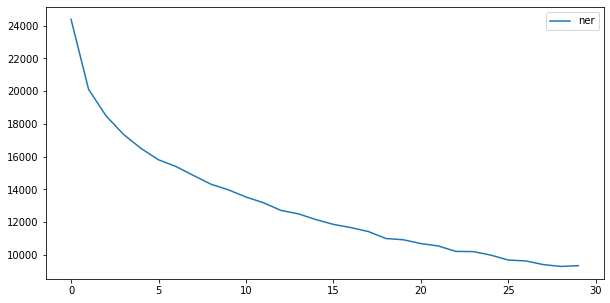

In [ ]:
# Visualize loss rate
train_losses = pd.DataFrame(loss)
train_losses.plot.line(figsize = (10,5))

##  6. Step: Evaluate machine learning model

In [ ]:
# Create a function to get ebay ner model performance evaluation metrix
def my_evaluate(model, examples):
  # Create Scorer class
  scorer = Scorer() 
  # Create empty list
  example = []
  # Loop through examples
  for input_, annotations in examples: 
    # Predict
    pred = model(input_)
    # print(pred, annotations)
    # Create Example instance
    temp = Example.from_dict(pred, annotations)
    # append to example list
    example.append(temp)
  # Get Scores
  scores = scorer.score(example)
  return scores

In [ ]:
# Load trained model
nlp = spacy.load('./trained_ebay_ner_model')
# Get score of model from my_evaluate
score = my_evaluate(nlp,TRAIN_DATA)
score

{'cats_auc_per_type': {},
 'cats_f_per_type': {},
 'cats_macro_auc': 0.0,
 'cats_macro_f': 0.0,
 'cats_macro_p': 0.0,
 'cats_macro_r': 0.0,
 'cats_micro_f': 0.0,
 'cats_micro_p': 0.0,
 'cats_micro_r': 0.0,
 'cats_score': 0.0,
 'cats_score_desc': 'macro F',
 'dep_las': None,
 'dep_las_per_type': None,
 'dep_uas': None,
 'ents_f': 0.9173983951986432,
 'ents_p': 0.9175061328879378,
 'ents_per_type': {'Accents': {'f': 0.940377358490566,
   'p': 0.9382530120481928,
   'r': 0.9425113464447806},
  'Brand': {'f': 0.9078760697450917,
   'p': 0.9052660399744455,
   'r': 0.9105011933174224},
  'Character': {'f': 0.9206349206349206, 'p': 1.0, 'r': 0.8529411764705882},
  'Character Family': {'f': 0.923076923076923,
   'p': 0.9152542372881356,
   'r': 0.9310344827586207},
  'Closure': {'f': 0.9279538904899136,
   'p': 0.9757575757575757,
   'r': 0.8846153846153846},
  'Color': {'f': 0.9662316138388233,
   'p': 0.9612530915086562,
   'r': 0.9712619741774261},
  'Country/Region of Manufacture': {'f': 

## 7. Step: Test machine learning custom NER model

In [ ]:
# Load trained model
nlp = spacy.load('./trained_ebay_ner_model')

# Collecting testing dataset from Listing Title Small (lt_sm) dataset and convert testing data to list format
sentance_list = lt_sm['Title'].tolist()
test = sentance_list[350:360]
test

["Urban Expressions Women 's Multi Clutch , Purse , Blue / White Pouch Wooden Bag",
 'Next Black And Silver Mini Clutch Bag',
 '1pc Strawberry Coin Bag Chic Multi-use Change Purse Coin Purse for Girl Q',
 'Thirty-One Zipper Pouch - Origami Pop Print * BRAND NEW *',
 'NEW BETSEY JOHNSON BETSEYVILLE PURSE HANDBAG BLACK AND PINK',
 'Avon Special Collection Bag shoulder bag',
 'COACH 1452 SOHO DUFFLE Leather Ivory Convertible Crossbody Shoulder Bag Mint',
 'Aspinal of London womens handbag / pouch',
 'Francesco Biasia Brown Handbag',
 'GUESS brown and tan studded handbag']

In [ ]:
# Pass test data into base ner model to extract entities and tags
for i in test:
    doc = nlp(i)
    results = []
    for ent in doc.ents:
      results.append([ent.text,ent.label_])
    print(results)

[['Urban', 'Brand'], ['Expressions', 'Brand'], ['Women', 'Department'], ["'s", 'Brand'], ['Multi', 'Pocket Type'], ['Clutch', 'Type'], [',', 'No Tag'], ['Purse', 'Type'], [',', 'No Tag'], ['Blue', 'Color'], ['/', 'Handle/Strap Material'], ['White', 'Color'], ['Pouch', 'Type'], ['Wooden', 'Handle/Strap Material'], ['Bag', 'Type']]
[['Next', 'No Tag'], ['Black', 'Brand'], ['And', 'Brand'], ['Silver', 'Hardware Material'], ['Mini', 'Model'], ['Clutch', 'Brand'], ['Bag', 'Brand']]
[['1pc', 'No Tag'], ['Strawberry', 'Model'], ['Coin', 'No Tag'], ['Bag', 'Type'], ['Chic', 'Obscure'], ['Multi-use', 'Color'], ['Change', 'Brand'], ['Purse', 'Type'], ['Coin', 'No Tag'], ['Purse', 'Type'], ['for', 'Brand'], ['Girl', 'Department'], ['Q', 'No Tag']]
[['Thirty', 'Brand'], ['One', 'Brand'], ['Zipper', 'Brand'], ['Pouch -', 'Color'], ['Pop', 'No Tag'], ['Print', 'No Tag'], ['*', 'No Tag'], ['BRAND', 'No Tag'], ['NEW', 'No Tag'], ['*', 'No Tag']]
[['NEW', 'No Tag'], ['BETSEY', 'Model'], ['JOHNSON', 'Br

## 8. Step: Pass test data into model and monitor performance

In [ ]:
# Load model
nlp = spacy.load('./ebay_rules_ner') 
# Create testing data
TEST_DATA = []
for item in lt_sm['Title'].tolist():
  doc = nlp(item)
  entities = []
  for ent in doc.ents:
    entities.append((ent.start_char, ent.end_char, ent.label_)) 
  if len(entities) > 0:
    TEST_DATA.append([item, {'entities': entities}]  )

# Save testing data
save_data('./ebay_testing_data.json', TEST_DATA)


In [ ]:
len(TEST_DATA)

9971

In [ ]:
# Load training dataset
TEST_DATA = load_data('./ebay_testing_data.json')

In [ ]:
# Load trained model
nlp = spacy.load('./trained_ebay_ner_model')
# Get score of model from my_evaluate
score = my_evaluate(nlp,TEST_DATA)
score

{'cats_auc_per_type': {},
 'cats_f_per_type': {},
 'cats_macro_auc': 0.0,
 'cats_macro_f': 0.0,
 'cats_macro_p': 0.0,
 'cats_macro_r': 0.0,
 'cats_micro_f': 0.0,
 'cats_micro_p': 0.0,
 'cats_micro_r': 0.0,
 'cats_score': 0.0,
 'cats_score_desc': 'macro F',
 'dep_las': None,
 'dep_las_per_type': None,
 'dep_uas': None,
 'ents_f': 0.5983024145580812,
 'ents_p': 0.5519447135823463,
 'ents_per_type': {'Accents': {'f': 0.5434861060988813,
   'p': 0.47033104309806373,
   'r': 0.6435897435897436},
  'Brand': {'f': 0.5469633517957427,
   'p': 0.5131259731324909,
   'r': 0.5855785123966942},
  'Character': {'f': 0.5540540540540541,
   'p': 0.640625,
   'r': 0.4880952380952381},
  'Character Family': {'f': 0.5316455696202531,
   'p': 0.4329896907216495,
   'r': 0.6885245901639344},
  'Closure': {'f': 0.6574074074074074,
   'p': 0.6558891454965358,
   'r': 0.6589327146171694},
  'Color': {'f': 0.7836221438429688,
   'p': 0.7384393063583815,
   'r': 0.8346945442665795},
  'Country/Region of Manufa

## Create train, test set to train NER model in SpaCy 3.0


In [ ]:
output_path = './ebay'

In [ ]:
import srsly
import typer
import warnings
from tqdm import tqdm
from pathlib import Path
from spacy.tokens import DocBin

def convert(lang: str, TRAIN_DATA, output_path: Path):
    nlp = spacy.blank(lang)
    db = DocBin()
    for text, annot in TRAIN_DATA:
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label)
            if span is None:
                msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                warnings.warn(msg)
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(output_path)

In [ ]:
train = load_data('./ebay_training_data.json')
valid = load_data('./ebay_testing_data.json')

In [ ]:
train[0]

['LOUIS VUITTON M40096 Handbag Priscilla Multi-color canvas Multi-color canvas',
 {'entities': [[0, 5, 'Product Line'],
   [6, 13, 'Brand'],
   [14, 20, 'MPN'],
   [21, 28, 'Type'],
   [29, 38, 'Model'],
   [39, 50, 'Color'],
   [51, 57, 'Brand'],
   [58, 69, 'Color'],
   [70, 76, 'Brand']]}]

In [ ]:
nlp = spacy.blank('en')
def create_training(TRAIN_DATA):
  db = DocBin()
  for text, annot in tqdm(TRAIN_DATA):
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in annot['entities']:
      span = doc.char_span(start, end, label = label, alignment_mode = 'contract')
      if span is None:
        print('Skipping entity')
      else:
        ents.append(span)
    doc.ents = ents
    db.add(doc)
  return(db)

In [ ]:
train = create_training(train)
train.to_disk('./data/train.spacy')

100%|██████████| 3471/3471 [00:01<00:00, 2766.91it/s]


In [ ]:
valid = create_training(valid)
valid.to_disk('./data/valid.spacy')

100%|██████████| 9971/9971 [00:05<00:00, 1742.49it/s]
